In [8]:
import numpy as np
import pandas as pd

# from matplotlib import pyplot as plt
# import seaborn as sns
# import math
# import gzip
from plotly import express as px
# from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
import sklearn
# import networkx as nx

In [24]:
import sklearn

In this update, we accessed the actual tweets data! Here are some summaries of what we did: 
1. continued exploring **clusterings**
2. used **tweets data** to calculate our own `production score`, then we used **the network dataset** to calculate our own `consumption score`, and checked their clusterings.
3. checked the **user network**

# Part 1: clustering

##  Data Cleaning

In [5]:
# domain score
domain_score = pd.read_csv("domains_ideology_score_LADA.txt", delimiter = "\t", header=None)
domain_score = domain_score.rename(columns={
    0: "domain",
    1: "score"
})


# user scores:
# polarity score
user_polarity = pd.read_csv("USER_POLARITY_BARBERA.txt", delimiter = "\t", header=None)
user_polarity = user_polarity.rename(columns={0: "user_ID", 1: "polarity_score"})
user_polarity = user_polarity.drop([2], axis=1)

# production score
user_production_score = pd.read_csv("obamacare/users_production_scores.txt", delimiter = "\t", header = None, lineterminator='\n')
user_production_score = user_production_score.rename(columns={0: "user_ID", 1: "production_score"})
user_production_score = user_production_score.drop([2,3], axis=1)

# consumption score
user_consumption_score = pd.read_csv("obamacare/users_consumption_scores.txt", delimiter = "\t", header = None, lineterminator='\n')
user_consumption_score = user_consumption_score.rename(columns={0: "user_ID", 1: "consumption_score"})
user_consumption_score = user_consumption_score.drop([2,3], axis=1)


# merge the scores
user_score = pd.merge(user_polarity, user_production_score, on = ["user_ID"])
user_score = pd.merge(user_score, user_consumption_score, on = "user_ID")
# drop rows with missing consumption/production score
user_score = user_score[user_score["consumption_score"] != 0]
user_score = user_score[user_score["production_score"] != 0]
# reset the index
user_score = user_score.reset_index().drop(["index"], axis = 1)

user_score.head(5)

user_ID  polarity_score  production_score  consumption_score
0   100005598       -2.061462          0.372880           0.327964
1   100122730        1.889076          0.608306           0.652830
2   100250921        1.995763          0.460730           0.542033
3   100271127        2.080835          0.569843           0.588955
4  1003130904       -2.308503          0.365888           0.352475

## Clustering

Our previuous k-means clustering wasn't very clear, and our rough clustering tells us that there could be a better clustering. Thus we continued exploring.

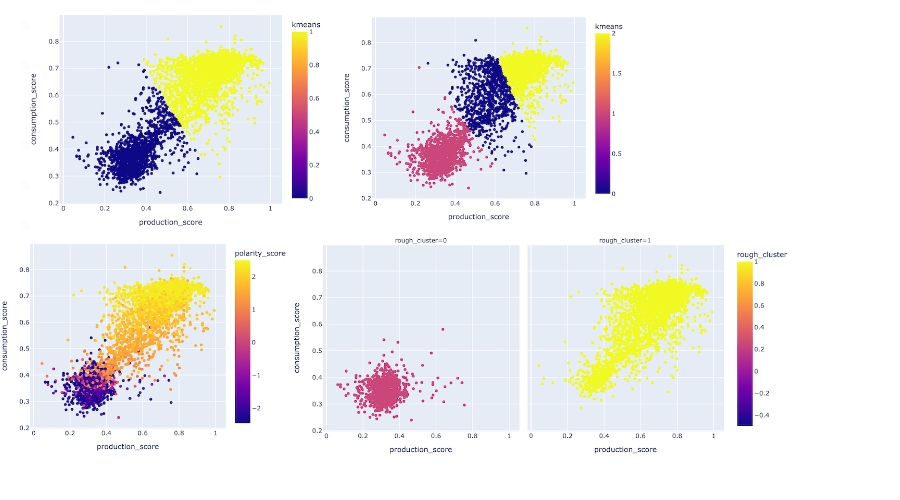

In [ ]:
#looks a bit "better" than K-means with 3 cluster, but still not that great for the center one

In [22]:
user_score_con = user_score[user_score["polarity_score"] > 0]
user_score_con = user_score_con.drop(["user_ID","polarity_score","rough_cluster","kmeans"],axis = 1)
kmeans = KMeans(n_clusters = 2)
kmeans.fit(user_score_con)
predicts = kmeans.predict(user_score_con)
user_score_con["rough_cluster_alt"] = predicts+1
user_score_con =user_score_con.drop(["consumption_score","production_score"],axis=1)

user_score = user_score.join(user_score_con)
user_score["rough_cluster_alt"] = user_score["rough_cluster_alt"].fillna(0)


fig = px.scatter(data_frame = user_score,
                 x = "production_score",
                 y = "consumption_score",
                 color = "rough_cluster_alt",
                 hover_name = "user_ID",
                 width = 600,
                 height = 500)
fig.show()

In [26]:
#spectural clustering:
def spectral_clustering(X,epsilon):
    A = sklearn.metrics.pairwise_distances(X)
    A = (A < epsilon)*1
    np.fill_diagonal(A,0)
    D = np.diag(np.sum(A,axis = 1))
    L = np.linalg.inv(D) @ (D-A)
    W,V = np.linalg.eig(L) 
    z_eig = V[:,np.argsort(W).tolist().index(1)]
    return (z_eig <0)*1

user_score_data = user_score[["production_score", "consumption_score"]]
spc_clus = spectral_clustering(user_score_data.to_numpy(),0.2)
user_score["spectral"] = spc_clus

fig = px.scatter(data_frame = user_score,
                 x = "production_score",
                 y = "consumption_score",
                 color = "spectral",
                 hover_name = "user_ID",
                 width = 600,
                 height = 500)
fig.show()

In [27]:
## Agglomerative Clustering
AC = sklearn.cluster.AgglomerativeClustering(n_clusters = 2, linkage = "ward")
AC.fit(train_user_score)
predicts = AC.labels_
user_score["AC"] = predicts
fig = px.scatter(data_frame = user_score,
                 x = "production_score",
                 y = "consumption_score",
                 color = "AC",
                 hover_name = "user_ID",
                 width = 600,
                 height = 500)
fig.show()

# Part 2: Score Calculation

- Since the dataset is very big, we created other notebooks to filter data with scores, and created databases `obama.db` (the tweet contents) and `obama_network.db` (user networks).

## Production Score

In [28]:
# read tweets database
import sqlite3
conn = sqlite3.connect("obama.db")
cursor = conn.cursor()
cmd = \
"""
SELECT user_ID, domain FROM tweets
"""
df = pd.read_sql_query(cmd, conn)
conn.close()

In [29]:
# data cleaning
domain_name = domain_score["domain"].to_numpy()
df["domain"] = df["domain"].str.split("a0a",expand = True)[1].str.split("/",expand = True)[2]
def del_www(x):
    if "www." in x:
        x = x[4:]
    return x
df["domain"] = df["domain"].dropna().astype(str).apply(del_www)
df["check"] = df["domain"].apply(lambda x: x in domain_name)
df_clean = df[df["check"] == True].reset_index().drop(["index","check"],axis = 1)
df_clean.head(5)

user_ID                         domain
0  115094250  thenewcivilrightsmovement.com
1  115094250                detroitnews.com
2  115094250                   dailykos.com
3  115094250                   dailykos.com
4  115094250                   dailykos.com

In [30]:
# calculate production score
df_domain = pd.merge(df_clean, domain_score, on = "domain")
df_domain.groupby(["user_ID"])["score"].mean()
our_production_score= df_domain.groupby(["user_ID"])["score"].mean().reset_index()
our_production_score = our_production_score.rename(columns={"score": "production_score"})
our_production_score.head(5)

user_ID  production_score
0    58523          0.760225
1    82433          0.236185
2   640893          0.646525
3   759251          0.347375
4   778057          0.215305

## Consumption Score

In [34]:
# read network database
conn = sqlite3.connect("obama_network.db")
cursor = conn.cursor()

cmd = \
"""
SELECT * FROM network
"""
df_network = pd.read_sql_query(cmd, conn)
conn.close()

In [35]:
# data cleaning
df_network = df_network.rename(columns={
    "following_ID": "user_ID",
    "user_ID" : "following_ID"    
})
df_network = pd.merge(df_network,
                      df_clean.groupby("user_ID").count().reset_index().rename(columns={"user_ID":"following_ID"}),
                      on = "following_ID")
df_network = pd.merge(df_network,
                      user_production_score.rename(columns={"user_ID":"following_ID"}),
                      on = "following_ID")
df_network = df_network.sort_values("user_ID").reset_index().drop(["index"],axis = 1)
df_network.head(5)

following_ID  user_ID  domain  production_score
0      16377693    58523      32          0.347375
1     138977055    58523       2          0.468342
2     104342107    58523      91          0.576057
3      19550464    58523     156          0.617872
4      16377693    58523      32          0.616218

In [36]:
# calculate consumption score
def product_sum(df):
    return sum(df['domain']*df['production_score']) / sum(df['domain'])
df_network.groupby("user_ID")['domain', 'production_score'].apply(product_sum)
our_consumption_score = df_network.groupby("user_ID")['domain', 'production_score'].apply(product_sum).reset_index()
our_consumption_score = our_consumption_score.rename(columns={0: "consumption_score"})
our_consumption_score.head(5)

<ipython-input-36-8b17d5446282>:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

<ipython-input-36-8b17d5446282>:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



user_ID  consumption_score
0    58523           0.683999
1    82433           0.382368
2   640893           0.633302
3   759251           0.351210
4   778057           0.449090

## Combine Our Own Scores

In [39]:
our_score = pd.merge(our_production_score, our_consumption_score, on = "user_ID")
our_score = our_score.dropna()
train_our_score = our_score.drop(["user_ID"],axis = 1)

In [40]:
## Agglomerative Clustering
AC = sklearn.cluster.AgglomerativeClustering(n_clusters = 2, linkage = "ward")
AC.fit(train_our_score)
predicts = AC.labels_
our_score["AC"] = predicts
fig = px.scatter(data_frame = our_score,
                 x = "production_score",
                 y = "consumption_score",
                 color = "AC",
                 hover_name = "user_ID",
                 width = 600,
                 height = 500)
fig.show()

In [41]:
# spectral clustering
spc_clus = spectral_clustering(train_our_score.to_numpy(),0.17)
our_score["spectral"] = spc_clus
fig = px.scatter(data_frame = our_score,
                 x = "production_score",
                 y = "consumption_score",
                 color = "spectral",
                 hover_name = "user_ID",
                 width = 600,
                 height = 500)
fig.show()

In [42]:
fig = px.density_heatmap(data_frame = our_score,
                         x = "production_score",
                         y = "consumption_score",
                         nbinsx = 100,
                         nbinsy = 100,
                         width  = 700,
                         height = 700,
                         marginal_y = "violin",
                         marginal_x = "histogram")
fig.show()

# Part 3: User Network

In [45]:
conn = sqlite3.connect("obama_network.db")
cursor = conn.cursor()
cmd = \
"""
SELECT * FROM network
"""
df_network = pd.read_sql_query(cmd, conn)
conn.close()
df_network = df_network.rename(columns={"following_ID": "follower_ID"})

In [ ]:
df_network["first_check"] = df_network["user_ID"].apply(lambda x: x in our_score["user_ID"].to_numpy()).reset_index()["user_ID"]
df_network["second_check"] = df_network["follower_ID"].apply(lambda x: x in our_score["user_ID"].to_numpy()).reset_index()["follower_ID"]
df_network = df_network[df_network["first_check"] == True].reset_index()
df_network = df_network[df_network["second_check"] == True].reset_index()
df_network = df_network[["user_ID", "follower_ID"]]

In [ ]:
G = nx.DiGraph()
#### CREATE NODES AND POSITION EMBEDDING USING THE PRODUCTION/CONSUMPTION SCORE
for i in range(len(our_score)):
    G.add_node(our_score["user_ID"][i], X = our_score["production_score"][i], Y = our_score["consumption_score"][i])
pos=nx.get_node_attributes(G,'pos')
for i in range(len(df_network)):
    G.add_edge(df_network["follower_ID"][i], df_network["user_ID"][i])
nx.write_gexf(G, "test.gexf")

Since the data is very huge, it takes networkx forever to run; below is how the network looks like:

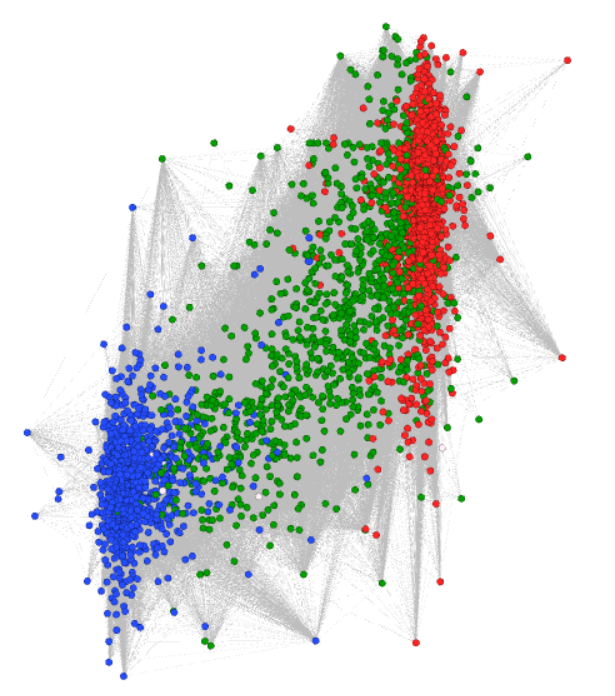

It's actually quite similar to the clustering we created using polarity scores!